## skpro introduction notebook

**Set-up instructions:** On binder, this should run out-of-the-box.

To run this notebook as intended, ensure that `skpro` with basic dependency requirements is installed in your python environment.

`skpro` provides `scikit-learn`-like, `scikit-base` compatible interfaces to:

* tabular **supervised regressors with probabilistic prediction modes** - interval, quantile and distribution predictions
* **performance metrics to evaluate probabilistic predictions**, e.g., pinball loss, empirical coverage, CRPS
* **reductions** to turn non-probabilistic, `scikit-learn` regressors into probabilistic `skpro` regressors, such as bootstrap or conformal
* tools for building **pipelines and composite machine learning models**, including tuning via probabilistic performance metrics
* symbolic an lazy **probability distributions** with a value domain of `pandas.DataFrame`-s and a `pandas`-like interface

**Section 1** provides an overview of common **probabilistic supervised regression workflows** supported by `skpro`.

**Section 2** gives an introduction to the different **prediction modes, performance metrics, and benchmarking tools**.

**Section 3** discusses **advanced composition patterns**, including various ways to add probabilistic capability to any `sklearn` regressor, pipeline building, tuning, ensembling.

**Section 4** gives an introduction to how to write **custom estimators** compliant with the `skpro` interface.

In [31]:
import warnings

# import numpy as np
# import pandas as pd

# hide warnings
warnings.filterwarnings("ignore")

## 1. Basic probabilistic supervised regression workflows <a class="anchor" id="chapter1"></a>

`skpro` revolves around supervised probabilistic regressors:

* `fit(X, y)` with tabular features `X`, labels `y`, same rows, both `pd.DataFrame`
* `predict_interval(X_test)` for interval predictions of labels
* `predict_quantiles(X_test)` for quantile predictions of labels
* `predict_var(X_test)` for variance predictions of labels
* `predict(X_test)` for mean predictions
* `predict_proba(X_test)` for distributional prediction

### 1.1 basic deployment workflow

`skpro` regressors are used via `fit` then `predict_proba` etc.

Same as `sklearn` regressors - `X` and `y` should be `pd.DataFrame` (`numpy` is also ok but not recommended)

In [32]:

from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from skpro.regression.residual import ResidualDouble

# step 1: data specification
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_new, y_train, _ = train_test_split(X, y)

# step 2: specifying the regressor
# example - random forest for mean prediction
# linear regression for variance prediction
reg_mean = RandomForestRegressor()
reg_resid = LinearRegression()
reg_proba = ResidualDouble(reg_mean, reg_resid)

# step 3: fitting the model to training data
reg_proba.fit(X_train, y_train)

# step 4: predicting labels on new data

# probabilistic prediction modes - pick any or multiple
# we show the return types in detail below

# full distribution prediction
y_pred_proba = reg_proba.predict_proba(X_new)

# interval prediction
y_pred_interval = reg_proba.predict_interval(X_new, coverage=0.9)

# quantile prediction
y_pred_quantiles = reg_proba.predict_quantiles(X_new, alpha=[0.05, 0.5, 0.95])

# variance prediction
y_pred_var = reg_proba.predict_var(X_new)

# mean prediction is same as "classical" sklearn predict, also available
y_pred_mean = reg_proba.predict(X_new)

### 1.1.1 distribution predictions

`y_pred_proba` is an `skpro` distribution - it has index and columns like `pd.DataFrame`

"we predict that true labels are distributed according to `y_pred_proba`"

(here: distribution marginal by row/columns)

In [33]:
y_pred_proba = reg_proba.predict_proba(X_new)
y_pred_proba

Normal(columns=Index(['target'], dtype='object'),
       index=Index([339, 404, 322, 100, 290, 130, 275,  80, 382,  40,
       ...
         9, 416,   6, 283, 398, 341, 247,  19, 244, 259],
      dtype='int64', length=111),
       mu=array([[137.41],
       [141.62],
       [270.91],
       [206.37],
       [247.86],
       [262.66],
       [178.93],
       [173.25],
       [242.75],
       [183.41],
       [228.97],
       [151.35],
       [ 90.43],
       [247.75],
       [ 73.62],
       [ 74.41],
       [239.13],
       [104.01],
       [106.43],
       [180.94]...
       [15.16363133],
       [19.30379359],
       [22.66462912],
       [23.67923876],
       [17.77744596],
       [21.89433121],
       [16.29905907],
       [15.35822641],
       [13.13348596],
       [19.61694092],
       [14.89267715],
       [15.24729615],
       [16.60149878],
       [19.08357884],
       [11.17763136],
       [15.22555496],
       [22.76662828],
       [14.67462078],
       [13.95380708],
       [17.49306395],
       [19.19104786],
       [15.11246243],
       [15.80461152],
       [13.98481769],
       [20.36679025]]))

`skpro` distribution objects are pandas-like

In [34]:
y_pred_proba.shape

(111, 1)

In [35]:
y_pred_proba.index  # same index as X_new

Index([339, 404, 322, 100, 290, 130, 275,  80, 382,  40,
       ...
         9, 416,   6, 283, 398, 341, 247,  19, 244, 259],
      dtype='int64', length=111)

In [36]:
y_pred_proba.columns  # same columns as X_new

Index(['target'], dtype='object')

distribution objects have `sample` and methods such as `mean`, `var`:

In [37]:
y_pred_proba.sample().head()

,target
339,155.926678
404,146.496600
322,282.272888
100,210.435748
290,278.444916


In [38]:
y_pred_proba.mean().head()

,target
339,137.41
404,141.62
322,270.91
100,206.37
290,247.86


In [39]:
y_pred_proba.var().head()

,target
339,315.800821
404,357.419962
322,82.837335
100,336.419952
290,392.437612


### 1.1.2 interval predictions

interval prediction `y_pred_interval` is a `pd.DataFrame`:

* rows are the same as `X_new`
* columns indicate variables, nominal coverage, and bottom/upper bound

"we predict that value in row falls between bottom/upper with 90% chance"

In [40]:
y_pred_interval = reg_proba.predict_interval(X_new, coverage=0.9)
y_pred_interval.head()

target            
            0.9            
          lower       upper
339  108.179659  166.640341
404  110.523131  172.716869
322  255.939362  285.880638
100  176.200499  236.539501
290  215.275387  280.444613

### 1.1.3 quantile predictions

quantile prediction `y_pred_quantiles` is a `pd.DataFrame`:

* rows are the same as `X_new`
* columns indicate variables, quantile points

"we predict the 5%, 50%, 95% quantile points for the row to be here"

In [41]:
y_pred_quantiles = reg_proba.predict_quantiles(X_new, alpha=[0.05, 0.5, 0.95])
y_pred_quantiles.head()

target                    
           0.05    0.50        0.95
339  108.179659  137.41  166.640341
404  110.523131  141.62  172.716869
322  255.939362  270.91  285.880638
100  176.200499  206.37  236.539501
290  215.275387  247.86  280.444613

### 1.1.4 mean and variance predictions

mean and variance predictions `y_pred_mean`, `y_pred_var` are `pd.DataFrame`-s:

* rows are the same as `X_new`
* columns are the same as `X_new`

entries are predictive mean and variance in row/column

In [42]:
y_pred_mean = reg_proba.predict(X_new)
y_pred_var = reg_proba.predict_var(X_new)

In [43]:
y_pred_mean.head()

,target
339,137.41
404,141.62
322,270.91
100,206.37
290,247.86


In [44]:
y_pred_var.head()

,target
339,315.800821
404,357.419962
322,82.837335
100,336.419952
290,392.437612


this is the same as taking the distribution prediction and taking mean/variance

(for distribution objects that estimate these precisely)

In [45]:
y_pred_proba.mean().head()

,target
339,137.41
404,141.62
322,270.91
100,206.37
290,247.86


In [46]:
y_pred_proba.var().head()

,target
339,315.800821
404,357.419962
322,82.837335
100,336.419952
290,392.437612


### 1.2 simple evaluation workflow for probabilistic predictions

for simple evaluation:

1. split the data into train/test set
2. make predictions of either type for test features
3. compute metric on test set, comparing test predictions to hend out test labels

Note:

* metrics will compare tabular ground truth to probabilistic prediction
* the metric will needs to be of a compatible type, e.g., for proba predictions

In [47]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from skpro.metrics import CRPS
from skpro.regression.residual import ResidualDouble

# step 1: data specification
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# step 2: specifying the regressor
# example - linear regression for mean prediction
# random forest for variance prediction
reg_mean = LinearRegression()
reg_resid = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, reg_resid)

# step 3: fitting the model to training data
reg_proba.fit(X_train, y_train)

# step 4: predicting labels on new data
y_pred_proba = reg_proba.predict_proba(X_test)

# step 5: specifying evaluation metric
metric = CRPS()

# step 6: evaluat metric, compare predictions to actuals
metric(y_test, y_pred_proba)

31.030547325229797

how do we know that metric is of right type? Via `scitype:y_pred` tag

In [48]:
metric.get_tags()
# scitype:y_pred is pred_proba - for proba predictions

{'estimator_type': 'estimator',
 'object_type': 'metric',
 'reserved_params': ['multioutput', 'score_average'],
 'scitype:y_pred': 'pred_proba',
 'lower_is_better': True}

how do we find metrics for a prediction type?

In [49]:
from skpro.registry import all_objects

all_objects("metric", as_dataframe=True, return_tags="scitype:y_pred")

,name,object,scitype:y_pred
0,CRPS,<class 'skpro.metrics._classes.CRPS'>,pred_proba
1,ConstraintViolation,<class 'skpro.metrics._classes.ConstraintViola...,pred_interval
2,EmpiricalCoverage,<class 'skpro.metrics._classes.EmpiricalCovera...,pred_interval
3,LogLoss,<class 'skpro.metrics._classes.LogLoss'>,pred_proba
4,PinballLoss,<class 'skpro.metrics._classes.PinballLoss'>,pred_quantiles
5,SquaredDistrLoss,<class 'skpro.metrics._classes.SquaredDistrLoss'>,pred_proba


extra note: quantile metrics can be applied to interval predictions as well

more details on metrics below

### 1.2.1 diagnostic visualisations

some useful diagnostic visualisations: variants of crossplots for probabilistic predictions

A. crossplot ground truth vs prediction intervals.

Works with both proba and interval predictions.

What to look for: intervals shouhld cut through the x = y line (green points)

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

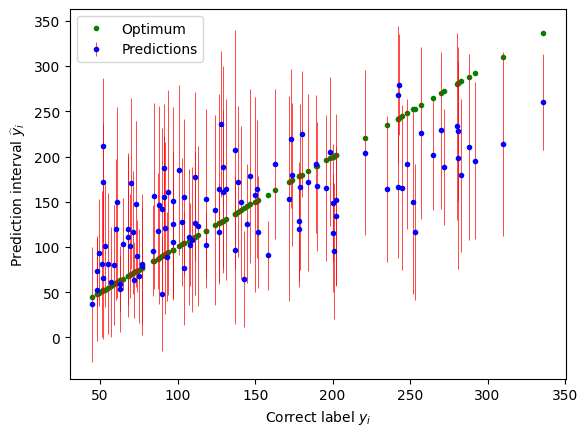

In [50]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

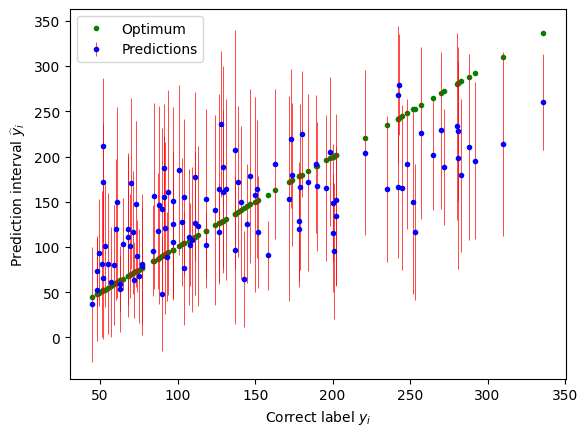

In [51]:
from skpro.utils.plotting import plot_crossplot_interval

y_pred_interval = reg_proba.predict_interval(X_test, coverage=0.9)
plot_crossplot_interval(y_test, y_pred_interval)

B. crossplot residuals vs predictive standard deviation

Works with both proba and variance predictions.

What to look for: should be close to a line, high linear correlation

<Axes: xlabel='Absolute errors $|y_i - \\widehat{y}_i|$', ylabel='Predictive standard deviation of $\\widehat{y}_i$'>

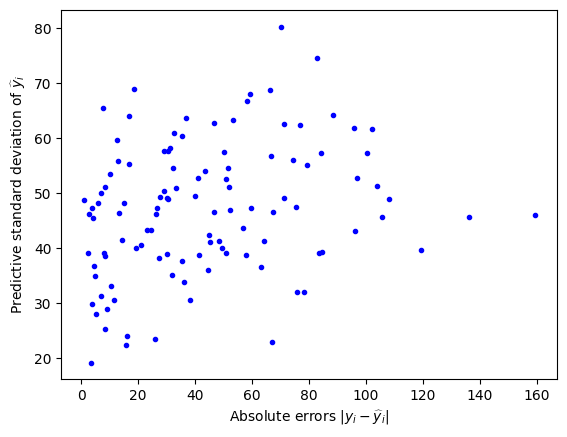

In [52]:
from skpro.utils.plotting import plot_crossplot_std

plot_crossplot_std(y_test, y_pred_proba)

<Axes: xlabel='Absolute errors $|y_i - \\widehat{y}_i|$', ylabel='Predictive standard deviation of $\\widehat{y}_i$'>

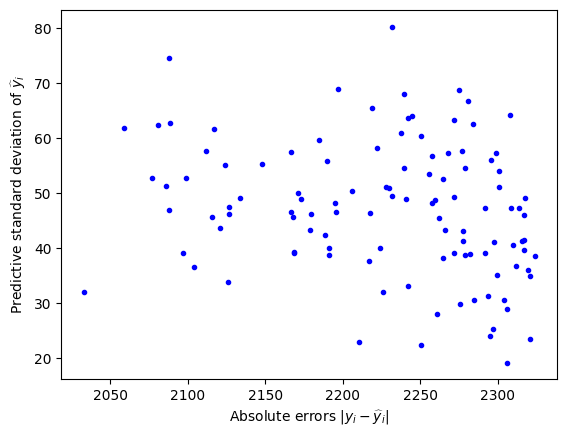

In [53]:
from skpro.utils.plotting import plot_crossplot_std

y_pred_var = reg_proba.predict_var(X_test)
plot_crossplot_std(y_test, y_pred_var)

C. crossplot ground truth vs loss values

Loss and prediction type should agree.

What to look for: association between accuracy and ground truth value

Diagnostic of which values we can predict more accurately,

e.g., to inform modelling or identify unusual outliers

<Axes: title={'center': 'mean CRPS: 31.03 +/- 2.23 sterr of mean'}, xlabel='Correct label $y_i$', ylabel='CRPS($y_i$, $\\widehat{y}_i$)'>

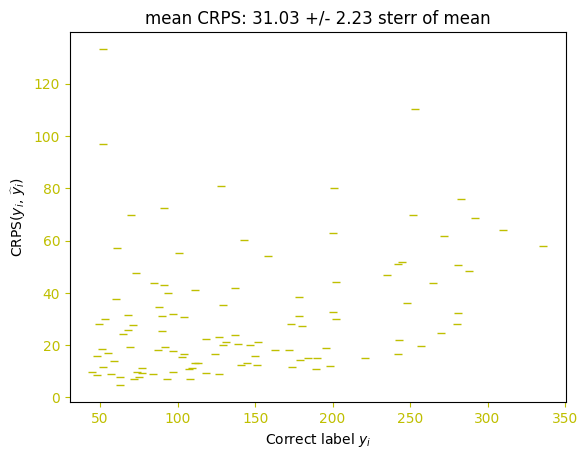

In [54]:
from skpro.utils.plotting import plot_crossplot_loss

crps_metric = CRPS()
plot_crossplot_loss(y_test, y_pred_proba, crps_metric)

### 1.3 searching for probabilistic regressors and metrics

all objects in `skpro` are indexed via the `registry` utility `all_objects`.

To find probabilistic supervised regressors, use `all_objects` with the type `regressor_proba`:

In [55]:
from skpro.registry import all_objects

all_objects("regressor_proba", as_dataframe=True).head()

,name,object
0,BootstrapRegressor,<class 'skpro.regression.bootstrap.BootstrapRe...
1,GridSearchCV,<class 'skpro.model_selection._tuning.GridSear...
2,Pipeline,<class 'skpro.regression.compose._pipeline.Pip...
3,RandomizedSearchCV,<class 'skpro.model_selection._tuning.Randomiz...
4,ResidualDouble,<class 'skpro.regression.residual.ResidualDoub...


a full list can also be found in the online API reference.

## 3. Advanced composition patterns <a class="anchor" id="chapter3"></a>

we introduce a number of composition patterns available in `skpro`:

* reducer-wrappers that turn `sklearn` regressors into probabilistic ones
* pipelines of `sklearn` transformers with `skpro` regressors
* tuning `skpro` probabilistic regressors via grid/random search, minimizing a probabilistic metric
* ensembling multiple `skpro` probabilistic regressors

data used in this section:

In [56]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

evaluation metric used in this section:

In [67]:
crps = CRPS()

### 3.1 Reducers to turn `sklearn` regressors probabilistic <a class="anchor" id="section3_1"></a>

there are many common algorithms that turn a non-probabilistic tabular regressor probabilistic

formally, this is a type of "reduction" - of probabilistic supervised tabular to non-probabilistic supervised tabular

Examples:

* predicting variance equal to training residual variance - `ResidualDouble` with standard settings
    * or other unconditional distribution estimate for residuals
* "squaring the residual" two-step prediction - `ResidualDouble`
* boostrap prediction intervals - `BootstrapRegressor`
* conformal prediction intervals - contributions appreciated :-)
* natural gradient boosting aka NGBoost - contributions appreciated :-)

### 3.1.1 constant variance prediction <a class="anchor" id="section3_1_1"></a>

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# estimator specification - use any sklearn regressor for reg_mean
reg_mean = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, cv=KFold(5))
# cv is used to estimate out-of-sample residual variance via 5-fold CV
# note - in-sample predictions will usually underestimate the variance!

# fit and predict
reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_test)

# evaluate
crps(y_test, y_pred_proba)

34.0113195645146

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

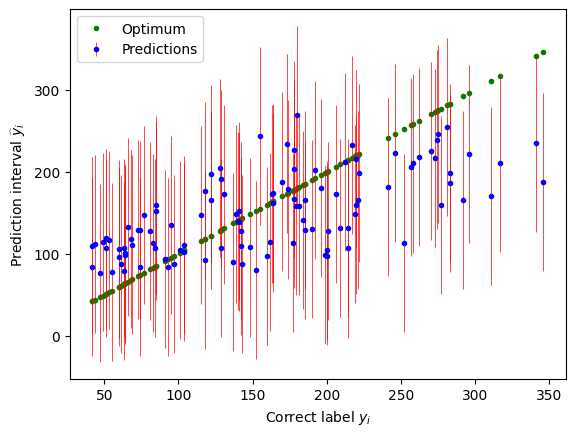

In [62]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)

### 3.1.2 two-step residual prediction <a class="anchor" id="section3_1_2"></a>

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# estimator specification - use any sklearn regressor for reg_mean and reg_resid
reg_mean = RandomForestRegressor()
reg_resid = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, estimator_resid=reg_resid, cv=KFold(5))
# cv is used to estimate out-of-sample residual variance via 5-fold CV

# fit and predict
reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_test)

# evaluate
crps(y_test, y_pred_proba)

33.885967850089116

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

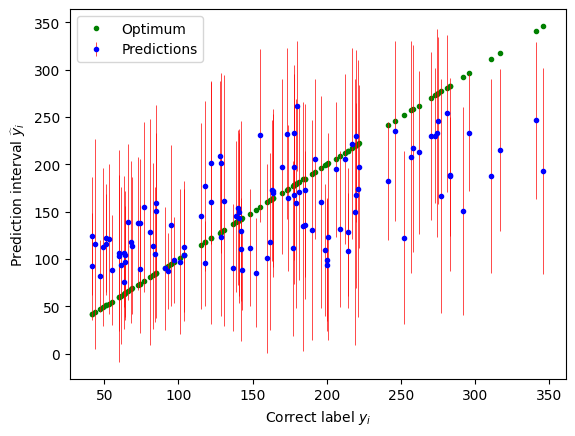

In [70]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)

### 3.1.3 bootstrap prediction intervals <a class="anchor" id="section3_1_3"></a>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from skpro.regression.bootstrap import BootstrapRegressor

# estimator specification - use any sklearn regressor for reg_mean
reg_mean = RandomForestRegressor()
reg_proba = BootstrapRegressor(reg_mean)

# fit and predict
reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_test)

# evaluate
crps(y_test, y_pred_proba)